# Chapter 3: Variational Autoencoders

An _autoencoder_ is an artificial neural network with two parts:

- An _encoder_ network which finds a representation of high dimensional data in a lower dimensional, or _latent_, space.

- A _decoder_ network which reconstruct samples of the original data from elements of the latent space.

## Your First Autoencoder

Below is an example of an autoencoder which uses convolutional layers for the encoder network and _convolutional transpose layers_ for the decoder. The model uses MSE for the loss function.

In [0]:
# Mount Google drive to save training checkpoints
from google.colab import drive

drive.mount('/content/gdrive/')

In [0]:
# Setup the model

from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, Flatten, Dense,
                                     Reshape, Conv2DTranspose, Activation)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

class Autoencoder():
  """Implements an autoencoder in Keras with an API for using the model."""

  def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
               encoder_conv_strides, z_dim, decoder_conv_filters,
               decoder_conv_kernel_size, decoder_conv_strides):
    encoder_input = Input(input_dim, name='encoder_input')
    x = encoder_input
    for i in range(len(encoder_conv_filters)):
      x = Conv2D(filters=encoder_conv_filters[i],
                 kernel_size=encoder_conv_kernel_size[i],
                 strides=encoder_conv_strides[i],
                 padding='same', name='encoder_conv_{}'.format(i))(x)
      x = LeakyReLU()(x)

    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    encoder_output = Dense(z_dim)(x)
    encoder = Model(encoder_input, encoder_output)
    self.encoder = encoder

    decoder_input = Input(shape=(z_dim,), name='decoder_input')
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    for i in range(len(decoder_conv_filters)):
      x = Conv2DTranspose(filters=decoder_conv_filters[i],
                          kernel_size=decoder_conv_kernel_size[i],
                          strides=decoder_conv_strides[i],
                          padding='same', name='decoder_conv_{}'.format(i))(x)
      if i < len(decoder_conv_filters) - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)
    decoder_output = x
    decoder = Model(decoder_input, decoder_output)
    self.decoder = decoder
    
    # Joining the models.
    self.model = Model(encoder_input, decoder(encoder_output))

    self.compiled = False

  def compile(self, learning_rate):
    """Compile the model."""
    if self.compiled:
      return
    opt = Adam(lr=learning_rate)
    mse = lambda y_act, y_pred: K.mean(K.square(y_act - y_pred), axis=(1, 2, 3))
    self.model.compile(opt, loss=mse)
    self.compiled = True

  def fit(self, X, y, batch_size, epochs, checkpoint_path=None):
    """Train the model."""
    if not self.compiled:
      raise Exception('Model not compiled')
    callbacks = []
    if checkpoint_path:
      callbacks.append(ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                                       save_weights_only=True))
    self.model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=True,
                   callbacks=callbacks)

  def load(self, checkpoint_path):
    """Load the model weights from the saved checkpoint file."""
    self.model.load_weights(checkpoint_path)

In [3]:
# Load the MNIST dataset.

from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Reshape these to be 4D tensors and scale the pixel values to [0, 1].

X_train = X_train.reshape(X_train.shape + (1,)) / 255.0
X_test = X_test.reshape(X_test.shape + (1,)) / 255.0

In [12]:
autoencoder = Autoencoder(input_dim=X_train.shape[1:],
                          encoder_conv_filters=(32, 64, 64, 64),
                          encoder_conv_kernel_size=(3, 3, 3, 3),
                          encoder_conv_strides=(1, 2, 2, 1),
                          z_dim=2,
                          decoder_conv_filters=(64, 64, 32, 1),
                          decoder_conv_kernel_size=(3, 3, 3, 3),
                          decoder_conv_strides=(1, 2, 2, 1))
autoencoder.model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0   

Now we will train the model for 200 training epochs, saving the model as we go using the `ModelCheckpoint` class. This will let us load the model later without having to go through the long training process.

In [0]:
# The path to save the model weights to in Drive.
checkpoint_path = '/content/gdrive/My Drive/gdl_models/autoencoder.hdf5'
autoencoder.compile(learning_rate=0.0005)

In [0]:
# Train the model. I removed the logs to remove visual noise.

autoencoder.fit(X_train, X_train, epochs=200, batch_size=32,
                checkpoint_path=checkpoint_path)

## Analysis of the Autoencoder

In [0]:
# Load the model from the checkpoint.

autoencoder.load(checkpoint_path)

### Reconstructing Digits

The following code plots a row of digits from the test set and the model's reconstruction of the respective image on the second row.

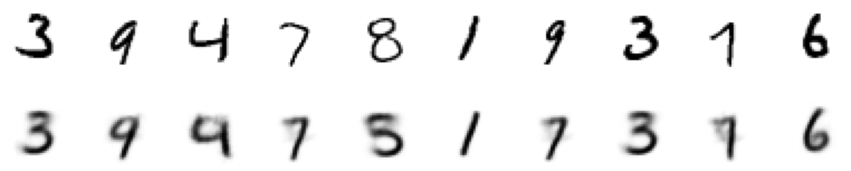

In [30]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(X_test)), n_to_show)

X_pred = autoencoder.model.predict(X_test[example_idx])

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, x in enumerate(X_test[example_idx]):
  ax = fig.add_subplot(2, n_to_show, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), cmap='gray_r')

for i, x in enumerate(X_pred):
  ax = fig.add_subplot(2, n_to_show, n_to_show + i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), cmap='gray_r')

### Plotting the Latent Space

Plotting a 2D scatter plot of the 5,000 images encoded into a point in the latent space. Each point's color indicates the digit's actual label.

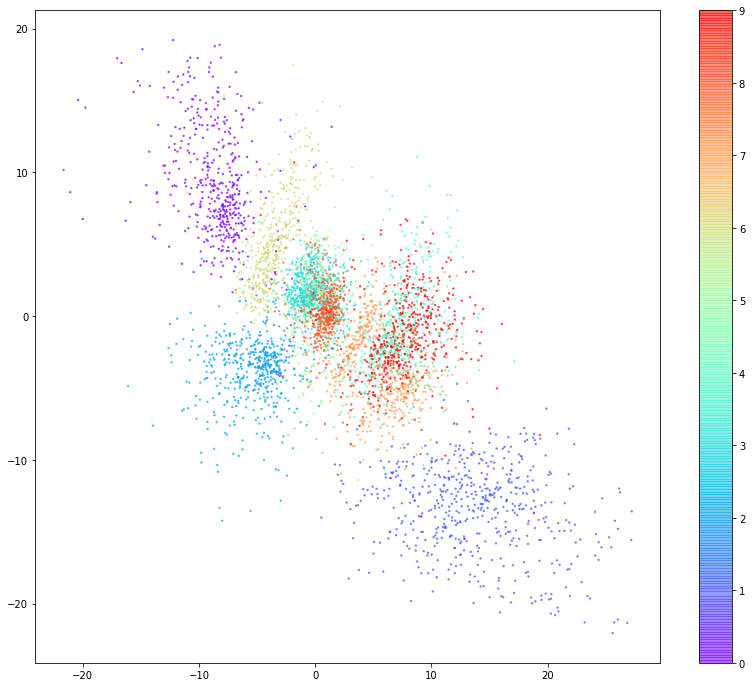

In [23]:
X_enc = autoencoder.encoder.predict(X_test[:5000])
plt.figure(figsize=(14, 12))
plt.scatter(X_enc[:,0], X_enc[:,1], cmap='rainbow', s=2, alpha=0.6,
            c=y_test[:5000])
plt.colorbar()

### Trying to Generate New Images

Below is an example that illustrates the problem with sampling from the latent space with an autoencoder. We can try randomly sampling from the latent space, but it may not yield good results.

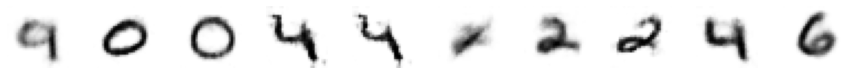

In [32]:
from random import random

min_x = min(X_enc[:, 0])
max_x = max(X_enc[:, 0])
min_y = min(X_enc[:, 1])
max_y = max(X_enc[:, 1])

n_to_show = 10

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
  ax = fig.add_subplot(1, n_to_show, i + 1)
  ax.axis('off')
  x = min_x + (random() * (max_x - min_x))
  y = min_y + (random() * (max_y - min_y))
  img = autoencoder.decoder.predict([[x, y]]).squeeze()
  ax.imshow(img, cmap='gray_r')